<a href="https://colab.research.google.com/github/SergioSarmientoRosales/MoNAS-SR-Predictors-Dataset/blob/main/Model_Based_MoNAS_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygmo
!pip install lifelines
!pip install -U kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 2.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=764741dd3ca6a4285150171057bf786aae7fd6b1b612d9ca81d83518d8cd06f4
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**NSGA Plots**

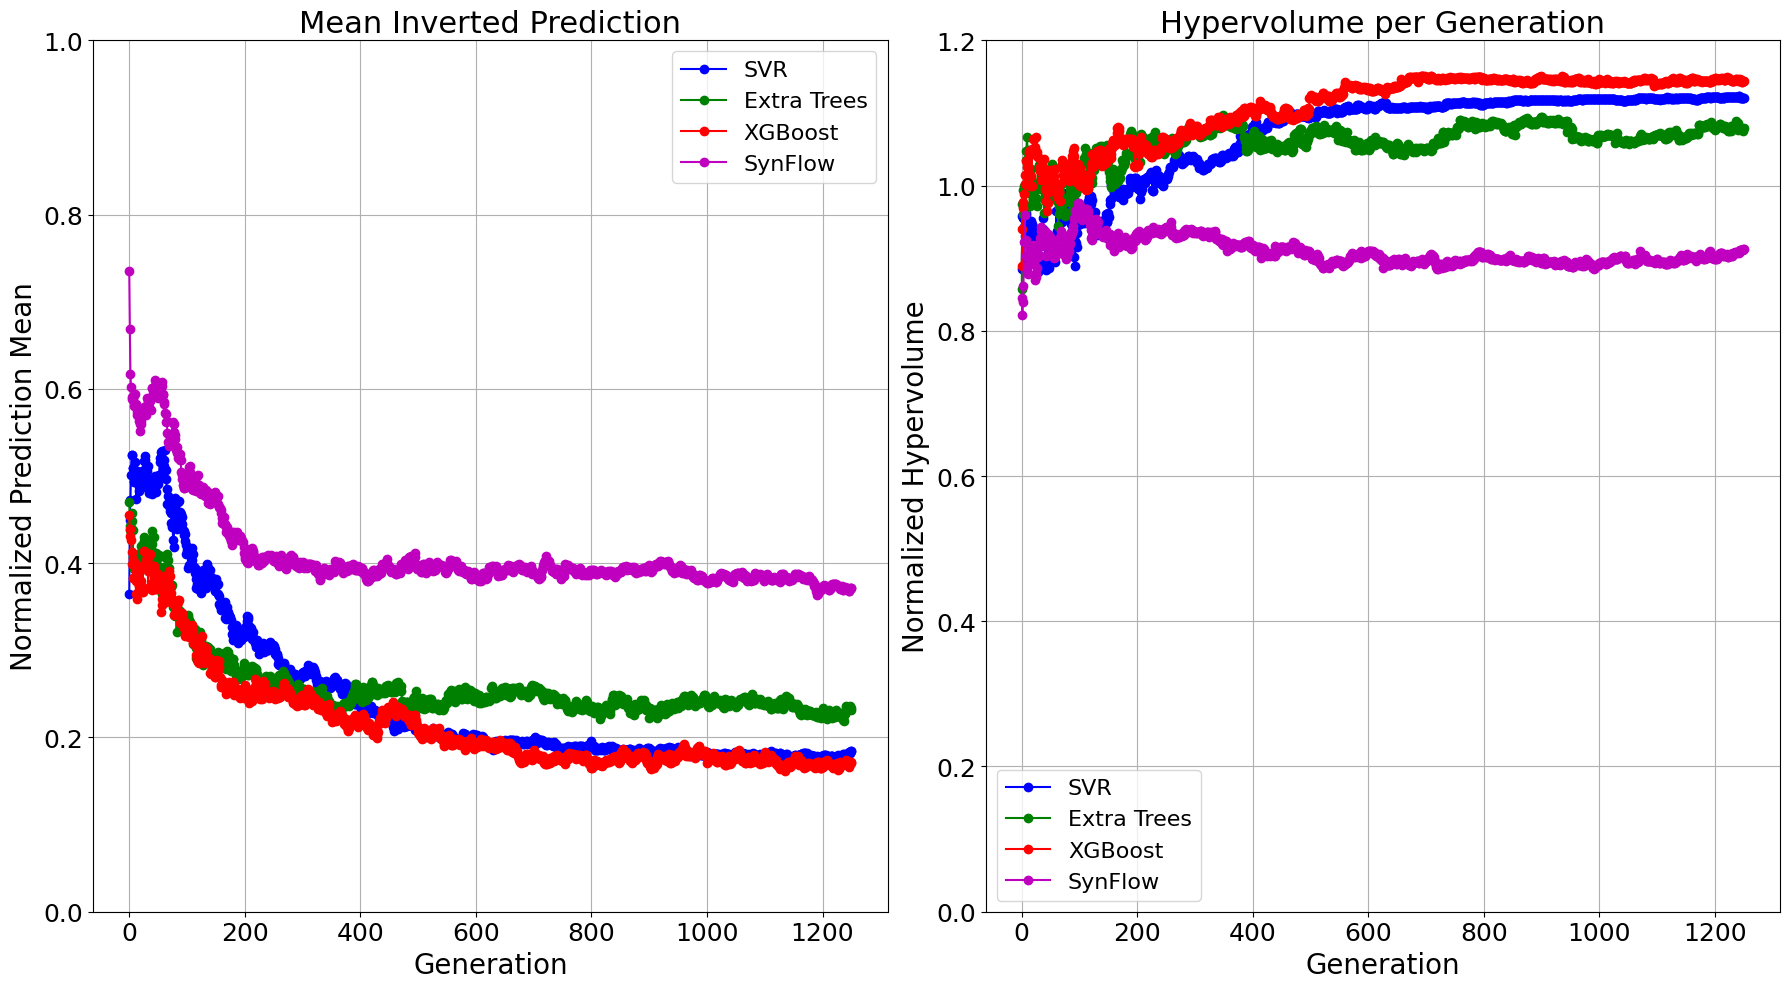

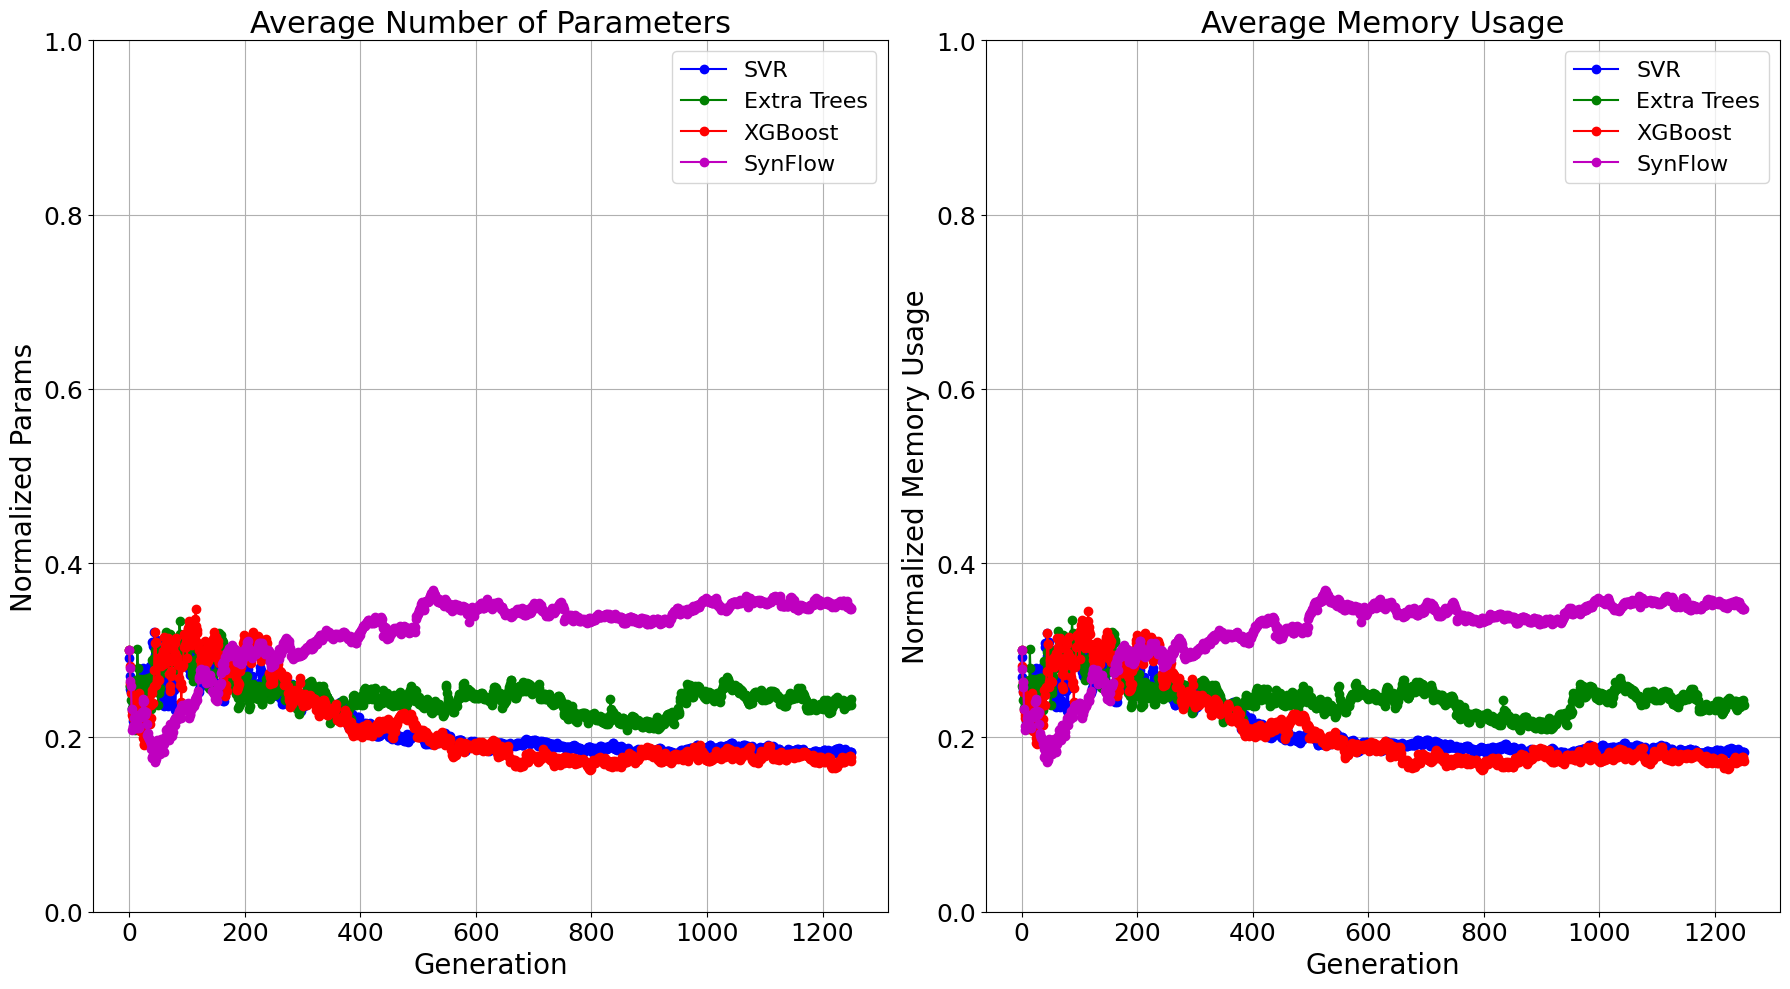

In [ ]:
import pandas as pd
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

def extract_number(file_path):
    match = re.search(r'seed_(\d+)', file_path)
    return int(match.group(1)) if match else float('inf')

def calculate_hypervolume(points, reference_point):
    sorted_points = points[np.argsort(points[:, 0])]
    hypervolume = 0.0
    ref = reference_point.copy()
    for i in range(len(points) - 1, -1, -1):
        if sorted_points[i][0] > ref[0] or sorted_points[i][1] > ref[1]:
            continue
        base = ref[0] - sorted_points[i][0]
        height = ref[1] - sorted_points[i][1]
        hypervolume += base * height
        ref[0] = sorted_points[i][0]
    return hypervolume

def read_and_process_file(filepath):
    number_pattern = re.compile(r'-?\d+\.?\d*(?:[eE]-?\d+)?')
    with open(filepath, 'r') as file:
        data = [list(map(float, number_pattern.findall(line.strip()[1:-1]))) for line in file]
    return pd.DataFrame(data, columns=[str(i) for i in range(len(data[0]))])

# Load files
file_paths = sorted(glob.glob('/content/drive/MyDrive/Seeds/SVR_Output_Population_seed_*.txt'), key=extract_number)
file_paths1 = sorted(glob.glob('/content/drive/MyDrive/Seeds/ExtraTrees_Output_Population_seed_*.txt'), key=extract_number)
file_paths2 = sorted(glob.glob('/content/drive/MyDrive/Seeds/XGBOOST_Output_Population_seed_*.txt'), key=extract_number)
file_paths3 = sorted(glob.glob('/content/drive/MyDrive/Seeds/Synflow_Output_Population_seed_*.txt'), key=extract_number)

# Data
datasets = [read_and_process_file(fp) for fp in file_paths]
datasets1 = [read_and_process_file(fp) for fp in file_paths1]
datasets2 = [read_and_process_file(fp) for fp in file_paths2]
datasets3 = [read_and_process_file(fp) for fp in file_paths3]

#Results dictionaries
results = {'mean': [], 'hypervolume': [], 'params_mean': [], 'memory_mean': []}
results1 = {'mean': [], 'hypervolume': [], 'params_mean': [], 'memory_mean': []}
results2 = {'mean': [], 'hypervolume': [], 'params_mean': [], 'memory_mean': []}
results3 = {'mean': [], 'hypervolume': [], 'params_mean': [], 'memory_mean': []}

def process_data(datasets, results):
    for df in datasets:
        hypervolume_values, mean_values = [], []
        mean_values_params, mean_values_memory = [], []
        for start in range(0, len(df), 20):
            block = df.iloc[start:start + 20].copy()
            if len(block) < 20:
                continue
            min_values, max_values = block.iloc[:, -3:].min(), block.iloc[:, -3:].max()
            block.iloc[:, -3:] = (block.iloc[:, -3:] - min_values) / (max_values - min_values)
            block = block.dropna()
            if len(block) == 0:
                continue
            hv = calculate_hypervolume(block.iloc[:, -3:].values, np.array([1.1, 1.1, 1.1]))
            hypervolume_values.append(hv)
            mean_values.append(block.iloc[:, -3].mean())
            mean_values_params.append(block.iloc[:, -2].mean())
            mean_values_memory.append(block.iloc[:, -1].mean())
        if hypervolume_values:
            results['mean'].append(mean_values)
            results['hypervolume'].append(hypervolume_values)
            results['params_mean'].append(mean_values_params)
            results['memory_mean'].append(mean_values_memory)

# Procesar todos los datasets
process_data(datasets, results)
process_data(datasets1, results1)
process_data(datasets2, results2)
process_data(datasets3, results3)

# Function to calculate statistics per generation
def compute_stats(key, results):
    if not results[key]:
        return [], []
    stats_means, stats_stds = [], []
    for i in range(len(results[key][0])):
        valid_values = [lst[i] for lst in results[key] if len(lst) > i]
        if valid_values:
            stats_means.append(np.mean(valid_values))
            stats_stds.append(np.std(valid_values))
        else:
            stats_means.append(np.nan)
            stats_stds.append(np.nan)
    return stats_means, stats_stds

# Calculate statistics
mean_of_means, _ = compute_stats('mean', results)
mean_of_means1, _ = compute_stats('mean', results1)
mean_of_means2, _ = compute_stats('mean', results2)
mean_of_means3, _ = compute_stats('mean', results3)

hypervolume_means, _ = compute_stats('hypervolume', results)
hypervolume_means1, _ = compute_stats('hypervolume', results1)
hypervolume_means2, _ = compute_stats('hypervolume', results2)
hypervolume_means3, _ = compute_stats('hypervolume', results3)

params_means, _ = compute_stats('params_mean', results)
params_means1, _ = compute_stats('params_mean', results1)
params_means2, _ = compute_stats('params_mean', results2)
params_means3, _ = compute_stats('params_mean', results3)

memory_means, _ = compute_stats('memory_mean', results)
memory_means1, _ = compute_stats('memory_mean', results1)
memory_means2, _ = compute_stats('memory_mean', results2)
memory_means3, _ = compute_stats('memory_mean', results3)

# Generations
x = np.arange(len(mean_of_means))

# First image: Prediction + Hypervolume
plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1)
plt.plot(x, mean_of_means, 'o-', color='b', label='SVR')
plt.plot(x, mean_of_means1, 'o-', color='g', label='Extra Trees')
plt.plot(x, mean_of_means2, 'o-', color='r', label='XGBoost')
plt.plot(x, mean_of_means3, 'o-', color='m', label='SynFlow')
plt.title('Mean Inverted Prediction', fontsize=22)
plt.xlabel('Generation', fontsize=20)
plt.ylabel('Normalized Prediction Mean', fontsize=20)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=18)

plt.subplot(1, 2, 2)
plt.plot(x, hypervolume_means, 'o-', color='b', label='SVR')
plt.plot(x, hypervolume_means1, 'o-', color='g', label='Extra Trees')
plt.plot(x, hypervolume_means2, 'o-', color='r', label='XGBoost')
plt.plot(x, hypervolume_means3, 'o-', color='m', label='SynFlow')
plt.title('Hypervolume per Generation', fontsize=22)
plt.xlabel('Generation', fontsize=20)
plt.ylabel('Normalized Hypervolume', fontsize=20)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=18)

plt.tight_layout()

plt.show()

# Second image: Params + Memory
plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1)
plt.plot(x, params_means, 'o-', color='b', label='SVR')
plt.plot(x, params_means1, 'o-', color='g', label='Extra Trees')
plt.plot(x, params_means2, 'o-', color='r', label='XGBoost')
plt.plot(x, params_means3, 'o-', color='m', label='SynFlow')
plt.title('Average Number of Parameters', fontsize=22)
plt.xlabel('Generation', fontsize=20)
plt.ylabel('Normalized Params', fontsize=20)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=18)

plt.subplot(1, 2, 2)
plt.plot(x, memory_means, 'o-', color='b', label='SVR')
plt.plot(x, memory_means1, 'o-', color='g', label='Extra Trees')
plt.plot(x, memory_means2, 'o-', color='r', label='XGBoost')
plt.plot(x, memory_means3, 'o-', color='m', label='SynFlow')
plt.title('Average Memory Usage', fontsize=22)
plt.xlabel('Generation', fontsize=20)
plt.ylabel('Normalized Memory Usage', fontsize=20)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=18)

plt.tight_layout()

plt.show()

**Non-Dominated + Weigth Sum**

In [ ]:


# Load CSV files
files = {
    "XGBoost": "/content/Filtered_XGB.csv",
    "SVR": "/content/Filtered_SVR.csv",
    "Extra Trees": "/content/Filtered_ET.csv",
    "SynFlow": "/content/Filtered_SynFlow.csv"  }# Baseline

# Read the files and add the "Model" column
df_list = []
for model, path in files.items():
    df = pd.read_csv(path)
    df["Model"] = model
    df_list.append(df)

# Concatenate all DataFrames
df_all = pd.concat(df_list, ignore_index=True)

# Normalize column names
column_mapping = {"Valid PSNR": "Valid PSNR", "params": "Params", "flops": "FLOPs"}
df_all.rename(columns=column_mapping, inplace=True)

# Convert columns to numeric values
df_all = df_all.dropna(subset=["Valid PSNR", "Params", "FLOPs"])
for col in ["Valid PSNR", "Params", "FLOPs"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# Normalize metrics (Min-Max Scaling)
df_all["Full_Normalized"] = (df_all["Valid PSNR"] - df_all["Valid PSNR"].min()) / (df_all["Valid PSNR"].max() - df_all["Valid PSNR"].min())
df_all["Params_Normalized"] = (df_all["Params"] - df_all["Params"].min()) / (df_all["Params"].max() - df_all["Params"].min())
df_all["FLOPs_Normalized"] = (df_all["FLOPs"] - df_all["FLOPs"].min()) / (df_all["FLOPs"].max() - df_all["FLOPs"].min())

def is_pareto_efficient(costs):
    """Finds Pareto-optimal points."""
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

# Apply Pareto criterion
costs = df_all[["Full_Normalized", "Params_Normalized", "FLOPs_Normalized"]].to_numpy()
costs[:, 0] *= -1  # Maximize PSNR
pareto_mask = is_pareto_efficient(costs)
df_pareto = df_all.loc[pareto_mask].copy()

# Plot non-dominated models with original metrics
fig_original = px.scatter_3d(df_pareto, x="Valid PSNR", y="Params", z="FLOPs", color="Model",
                             labels={"Valid PSNR": "PSNR", "Params": "Params", "FLOPs": "FLOPs"},
                             title="Non-Dominated Models (Pareto Front - Original Values)")
fig_original.show()

# Plot non-dominated models with normalized values and axes from 0 to 1
fig_normalized = px.scatter_3d(df_pareto,
                               x="Full_Normalized",
                               y="Params_Normalized",
                               z="FLOPs_Normalized",
                               color="Model",
                               labels={"Full": "PSNR (Normalized)"},
                               title="Non-Dominated Models (Pareto Front - Normalized Values)")

# Set axes range to [0,1]
fig_normalized.update_layout(
    scene=dict(
        xaxis=dict(range=[0, 1], title="PSNR "),
        yaxis=dict(range=[0, 1], title="Params"),
        zaxis=dict(range=[0, 1], title="FLOPs")
    )
)

fig_normalized.show()

# Compute Weighted Sum (equal weights)
df_pareto["Weighted_Sum"] = df_pareto["Full_Normalized"] - df_pareto["Params_Normalized"] - df_pareto["FLOPs_Normalized"]
print("\nTop 10 Weighted Sum:")
print(df_pareto[["Model", "Weighted_Sum"]].sort_values(by="Weighted_Sum", ascending=False).head(10))

# Compute Distance to Ideal
ideal = [df_pareto["Full_Normalized"].max(), df_pareto["Params_Normalized"].min(), df_pareto["FLOPs_Normalized"].min()]
df_pareto["Distance_to_Ideal"] = np.sqrt((df_pareto["Full_Normalized"] - ideal[0])**2 +
                                         (df_pareto["Params_Normalized"] - ideal[1])**2 +
                                         (df_pareto["FLOPs_Normalized"] - ideal[2])**2)
print("\nTop 10 Distance to Ideal:")
print(df_pareto[["Model", "Distance_to_Ideal"]].sort_values(by="Distance_to_Ideal").head(10))

# Save non-dominated models to CSV
df_pareto.to_csv("non_dominated_models_normalized.csv", index=False)
print("\nFile 'non_dominated_models_normalized.csv' successfully saved.")


Top 10 Weighted Sum:
          Model  Weighted_Sum
12          SVR      0.716262
40      SynFlow      0.702620
22          SVR      0.696171
17          SVR      0.669584
33  Extra Trees      0.619558
32  Extra Trees      0.615531
24  Extra Trees      0.610176
8       XGBoost      0.529042
34  Extra Trees      0.521223
11          SVR      0.511351

Top 10 Distance to Ideal:
          Model  Distance_to_Ideal
24  Extra Trees           0.235519
40      SynFlow           0.238267
12          SVR           0.265503
22          SVR           0.291200
11          SVR           0.315330
17          SVR           0.318444
33  Extra Trees           0.374467
32  Extra Trees           0.380467
8       XGBoost           0.467633
34  Extra Trees           0.478777

File 'non_dominated_models_normalized.csv' successfully saved.


**Hypervolume**

In [ ]:
import pandas as pd
import pygmo as pg

def normalize(column):
    return (column - column.min()) / (column.max() - column.min()) if column.max() != column.min() else column

def compute_normalized_hv(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={"FLOPs": "FLOPS"}, inplace=True)

    #
    df_obj = df[["Valid PSNR", "Params", "FLOPS"]].copy()
    df_obj["Valid PSNR"] *= -1  # Convertir PSNR a problema de maximización (invertir)

    # Normalización individual por archivo
    df_obj["Valid PSNR_Norm"] = normalize(df_obj["Valid PSNR"])
    df_obj["Params_Norm"] = normalize(df_obj["Params"])
    df_obj["FLOPS_Norm"] = normalize(df_obj["FLOPS"])

    # Convertir a lista de listas
    points = df_obj[["Valid PSNR_Norm", "Params_Norm", "FLOPS_Norm"]].to_numpy().tolist()

    # Referencia para hipervolumen normalizado
    ref_point = [1.1, 1.1, 1.1]

    # Calcular hipervolumen
    hv = pg.hypervolume(points).compute(ref_point)
    return hv

# Rutas a los archivos
file_paths = {
    "XGBoost": "/content/Filtered_XGB.csv",
    "SVR": "/content/Filtered_SVR.csv",
    "Extra Trees": "/content/Filtered_ET.csv",
    "SynFlow": "/content/Filtered_SynFlow.csv"  }# Baseline

# Calcular hipervolumen normalizado (real) para cada método
for name, path in file_paths.items():
    hv = compute_normalized_hv(path)
    print(f"{name} Normalized Hypervolume (Valid PSNR, Params, FLOPS): {hv:.4f}")

XGBoost Normalized Hypervolume (Valid PSNR, Params, FLOPS): 1.0591
SVR Normalized Hypervolume (Valid PSNR, Params, FLOPS): 0.8175
Extra Trees Normalized Hypervolume (Valid PSNR, Params, FLOPS): 1.0312
SynFlow Normalized Hypervolume (Valid PSNR, Params, FLOPS): 1.1431


**Inverted Generational Distance**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

# Load the CSV files
files ={
    "XGBoost": "/content/Filtered_XGB.csv",
    "SVR": "/content/Filtered_SVR.csv",
    "Extra Trees": "/content/Filtered_ET.csv",
    "SynFlow": "/content/Filtered_SynFlow.csv"  }# Baseline


# Read the files and label with model name
df_list = []
for model, path in files.items():
    df = pd.read_csv(path)
    df["Model"] = model
    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True)

# Standardize column names
df_all.rename(columns={"Valid PSNR": "Valid PSNR", "params": "Params", "flops": "FLOPs"}, inplace=True)

# Drop rows with NaNs and convert to numeric
df_all.dropna(subset=["Valid PSNR", "Params", "FLOPs"], inplace=True)
for col in ["Valid PSNR", "Params", "FLOPs"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# Z-score normalization
epsilon = 1e-8
for col in ["Valid PSNR", "Params", "FLOPs"]:
    mean = df_all[col].mean()
    std = df_all[col].std()
    df_all[f"{col}_Normalized"] = (df_all[col] - mean) / (std + epsilon)

# Invert Valid PSNR since it should be maximized (now minimized)
df_all["Valid PSNR_Normalized"] *= -1

# Construct the ideal reference point (best per objective)
ideal_point = np.min(df_all[["Valid PSNR_Normalized", "Params_Normalized", "FLOPs_Normalized"]].to_numpy(), axis=0)

# Function to compute IGD as mean distance to the ideal point
def calculate_igd_to_ideal(generated_points, ideal_point):
    if len(generated_points) == 0:
        return float("inf")
    return np.mean([distance.euclidean(p, ideal_point) for p in generated_points])

# IGD computation per model
models = df_all["Model"].unique()
igd_results = {}

for model in models:
    df_model = df_all[df_all["Model"] == model]
    points = df_model[["Valid PSNR_Normalized", "Params_Normalized", "FLOPs_Normalized"]].to_numpy()
    igd = calculate_igd_to_ideal(points, ideal_point)
    igd_results[model] = igd

# Show results
for model, igd in igd_results.items():
    print(f"IGD to ideal point for {model}: {igd:.6f}")


IGD to ideal point for XGBoost: 2.564752
IGD to ideal point for SVR: 2.044508
IGD to ideal point for Extra Trees: 1.981712
IGD to ideal point for SynFlow: 3.023364


**Hausdorff Distance**

In [ ]:
import pandas as pd
import numpy as np
import itertools

# Load CSV files
files = {
    "XGBoost": "/content/Filtered_XGB.csv",
    "SVR": "/content/Filtered_SVR.csv",
    "Extra Trees": "/content/Filtered_ET.csv",
    "SynFlow": "/content/Filtered_SynFlow.csv"  }# Baseline

# Read and concatenate all CSVs
df_list = [pd.read_csv(path).assign(Model=model) for model, path in files.items()]
df_all = pd.concat(df_list, ignore_index=True)

# Rename columns for consistency
df_all.rename(columns={"Valid PSNR": "Valid PSNR", "params": "Params", "flops": "FLOPs"}, inplace=True)

# Drop missing values and convert to float
df_all = df_all.dropna(subset=["Valid PSNR", "Params", "FLOPs"]).astype({
    "Valid PSNR": float, "Params": float, "FLOPs": float
})

# Normalize using Min-Max scaling
for col in ["Valid PSNR", "Params", "FLOPs"]:
    df_all[f"{col}_Normalized"] = (df_all[col] - df_all[col].min()) / (df_all[col].max() - df_all[col].min())

# Pareto efficiency function
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

# Average Hausdorff Distance function
def hausdorff_distance_average(A, B):
    def min_dist(p, Q):
        return np.min(np.linalg.norm(Q - p, axis=1))
    forward = np.mean([min_dist(a, B) for a in A])
    backward = np.mean([min_dist(b, A) for b in B])
    return (forward + backward) / 2

# ----------------------
# Get individual Pareto fronts
pareto_fronts = {}
pareto_counts = {}

for model in files.keys():
    df_model = df_all[df_all["Model"] == model]
    values = df_model[["Valid PSNR_Normalized", "Params_Normalized", "FLOPs_Normalized"]].to_numpy()
    values[:, 0] *= -1  # Invert PSNR for minimization
    mask = is_pareto_efficient(values)
    pareto = values[mask]
    pareto[:, 0] *= -1  # Restore PSNR
    pareto_fronts[model] = pareto
    pareto_counts[model] = pareto.shape[0]

# ----------------------
# Compute global Pareto front
all_values = df_all[["Valid PSNR_Normalized", "Params_Normalized", "FLOPs_Normalized"]].to_numpy()
all_values[:, 0] *= -1  # Maximize PSNR by minimizing its inverse
global_mask = is_pareto_efficient(all_values)
pareto_global = all_values[global_mask]
pareto_global[:, 0] *= -1  # Restore PSNR

# ----------------------
# Print number of Pareto solutions
print("🔹 Number of non-dominated (Pareto) solutions per method:")
for model, count in pareto_counts.items():
    print(f"{model}: {count} solutions")
print(f"Global Pareto Front (all methods combined): {pareto_global.shape[0]} solutions")

# ----------------------
# Strategy 1: AHD between SynFlow and others only
print("\n🔹 Average Hausdorff Distance (AHD) between SynFlow and other methods:")
synflow_pf = pareto_fronts["SynFlow"]
ahd_vs_synflow = {}

for model in files.keys():
    if model == "SynFlow":
        continue
    ahd = hausdorff_distance_average(pareto_fronts[model], synflow_pf)
    ahd_vs_synflow[model] = ahd
    print(f"{model} ↔ SynFlow: {ahd:.6f}")

# ----------------------
# Strategy 2: AHD of each method vs. Global Pareto Front
print("\n🔹 AHD of each method vs. Global Pareto Front:")
ahd_vs_global = {}
for model in files.keys():
    ahd = hausdorff_distance_average(pareto_fronts[model], pareto_global)
    ahd_vs_global[model] = ahd
    print(f"{model} → Global Pareto: {ahd:.6f}")

# Best method according to AHD vs Global
best_model = min(ahd_vs_global, key=ahd_vs_global.get)
print(f"\n✅ Best method compared to Global Pareto Front: {best_model} (AHD = {ahd_vs_global[best_model]:.6f})")

🔹 Number of non-dominated (Pareto) solutions per method:
XGBoost: 6 solutions
SVR: 5 solutions
Extra Trees: 8 solutions
SynFlow: 3 solutions
Global Pareto Front (all methods combined): 11 solutions

🔹 Average Hausdorff Distance (AHD) between SynFlow and other methods:
XGBoost ↔ SynFlow: 0.163206
SVR ↔ SynFlow: 0.108803
Extra Trees ↔ SynFlow: 0.145568

🔹 AHD of each method vs. Global Pareto Front:
XGBoost → Global Pareto: 0.073500
SVR → Global Pareto: 0.032311
Extra Trees → Global Pareto: 0.035203
SynFlow → Global Pareto: 0.064120

✅ Best method compared to Global Pareto Front: SVR (AHD = 0.032311)


**C-index**

In [ ]:
import pandas as pd
from lifelines.utils import concordance_index

def process_file_and_cindex(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    df.rename(columns={"FLOPs": "FLOPS"}, inplace=True)

    # Valid PSNR and Predicted PSNR
    if "Predicted PSNR" not in df.columns:
        return None # Return None if 'Predicted PSNR' column is missing

    predicted = df["Predicted PSNR"]
    full = df["Valid PSNR"]

    # Drop rows with missing predicted values
    combined = pd.DataFrame({'predicted': predicted, 'full': full}).dropna()

    if len(combined) == 0:
        return None # Return None if no valid data points

    # Calculate the C-index directly with real values
    cindex = concordance_index(combined['full'], combined['predicted'])

    return cindex

# Define the file paths
file_paths =  {
    "XGBoost": "/content/Filtered_XGB.csv",
    "SVR": "/content/Filtered_SVR.csv",
    "Extra Trees": "/content/Filtered_ET.csv",
    "SynFlow": "/content/Filtered_SynFlow.csv"  }# Baseline

# Compute and print C-index for each model
for model, path in file_paths.items():
    cindex = process_file_and_cindex(path)
    if cindex is not None:
        print(f"C-index for {model}: {cindex:.4f}")
    else:
        print(f"C-index for {model}: Not applicable (no predicted values)")

C-index for XGBoost: 0.8727
C-index for SVR: 0.6410
C-index for Extra Trees: 0.8727
C-index for SynFlow: 0.7647


**MSE**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def process_file_and_mse(file_path):
    # Leer archivo CSV
    df = pd.read_csv(file_path)
    df.rename(columns={"FLOPs": "FLOPS"}, inplace=True)

    # Extraer columnas Valid PSNR and Predicted PSNR
    if "Predicted PSNR" not in df.columns:
        return None # Return None if 'Predicted PSNR' column is missing

    objectives_predicted = df["Predicted PSNR"]
    objectives_full = df["Valid PSNR"]

    # Drop rows with missing predicted values
    combined = pd.DataFrame({'predicted': objectives_predicted, 'full': objectives_full}).dropna()

    if len(combined) == 0:
        return None # Return None if no valid data points

    # Calcular MSE between Valid PSNR and Predicted PSNR
    mse = mean_squared_error(combined['full'], combined['predicted'])

    return mse


# Paths for each dataset
file_paths =  {
    "XGBoost": "/content/Filtered_XGB.csv",
    "SVR": "/content/Filtered_SVR.csv",
    "Extra Trees": "/content/Filtered_ET.csv",
    "SynFlow": "/content/Filtered_SynFlow.csv"  }# Baseline

# Calculate and print MSE for each dataset
for model, path in file_paths.items():
    mse_value = process_file_and_mse(path)
    if mse_value is not None:
        print(f"MSE for {model}: {mse_value:.4f}")
    else:
        print(f"MSE for {model}: Not applicable (no predicted values)")

MSE for XGBoost: 26.4072
MSE for SVR: 2.0243
MSE for Extra Trees: 2.6760
MSE for SynFlow: 105161366712.4364
